In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split as split


In [2]:
#read file
df = pd.read_csv('global-data-on-sustainable-energy (1).csv')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

In [4]:
#check for duplicates
num_duplicates = df.duplicated().sum()
print("Number of Duplicate Rows:", num_duplicates)

Number of Duplicate Rows: 0


In [5]:
#print the inconsistent column name and their data types
for col in df.columns:
    if 'Density' in col:
        print(f"Column Name: {col}, Data Type: {df[col].dtype}")

# Fixing inconsistency in column names and converting 'Density' columns to float
df = df.rename(columns={col: 'Density' for col in df.columns if 'Density' in col})
df['Density'] = df['Density'].astype(str).str.replace(',', '').astype(float)



Column Name: Density\n(P/Km2), Data Type: object


In [6]:
#check for missing values
df.isna().sum()

Entity                                                                 0
Year                                                                   0
Access to electricity (% of population)                               10
Access to clean fuels for cooking                                    169
Renewable-electricity-generating-capacity-per-capita                 931
Financial flows to developing countries (US $)                      2089
Renewable energy share in the total final energy consumption (%)     194
Electricity from fossil fuels (TWh)                                   21
Electricity from nuclear (TWh)                                       126
Electricity from renewables (TWh)                                     21
Low-carbon electricity (% electricity)                                42
Primary energy consumption per capita (kWh/person)                     0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          207
Value_co2_emissions_kt_by_country                  

In [7]:
# remove rows with too many missing values
df = df.drop(columns = ['Financial flows to developing countries (US $)'])
df = df.drop(columns = ['Renewables (% equivalent primary energy)'])
df = df.drop(columns = ['Renewable-electricity-generating-capacity-per-capita'])

# drop rows where critical columns are missing
df = df.dropna(subset=['Latitude', 'Longitude', 'Land Area(Km2)', 'Density'])

# impute missing values based on Entity
columns_to_fill = [
    'Access to clean fuels for cooking', 
    'Renewable energy share in the total final energy consumption (%)', 
    'Electricity from nuclear (TWh)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 
    'Value_co2_emissions_kt_by_country', 'gdp_growth','gdp_per_capita',
    'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)', 
    'Low-carbon electricity (% electricity)', 'Access to electricity (% of population)'
]

for col in columns_to_fill:
    # impute mean by Entity
    df[col] = df.groupby('Entity')[col].transform(lambda x: x.fillna(x.mean()))
    
    # impute global mean as fallback
    global_mean = df[col].mean()
    df[col] = df[col].fillna(global_mean)

In [8]:
# encode categorical variables (entity)
label_encoder = LabelEncoder()
df['Entity_encoded'] = label_encoder.fit_transform(df['Entity'])

In [9]:
#sort values by Year and Entity
df = df.sort_values(by=['Year', 'Entity']).reset_index(drop=True)

# Define features and target variable
X = df.drop(columns = ['Primary energy consumption per capita (kWh/person)','Entity'])
y = df['Primary energy consumption per capita (kWh/person)']


--- Model-based Selection ---
1. Access to clean fuels for cooking
2. Renewable energy share in the total final energy consumption (%)
3. Energy intensity level of primary energy (MJ/$2017 PPP GDP)
4. gdp_per_capita
5. Density
6. Land Area(Km2)
7. Latitude
8. Longitude
9. Entity_encoded


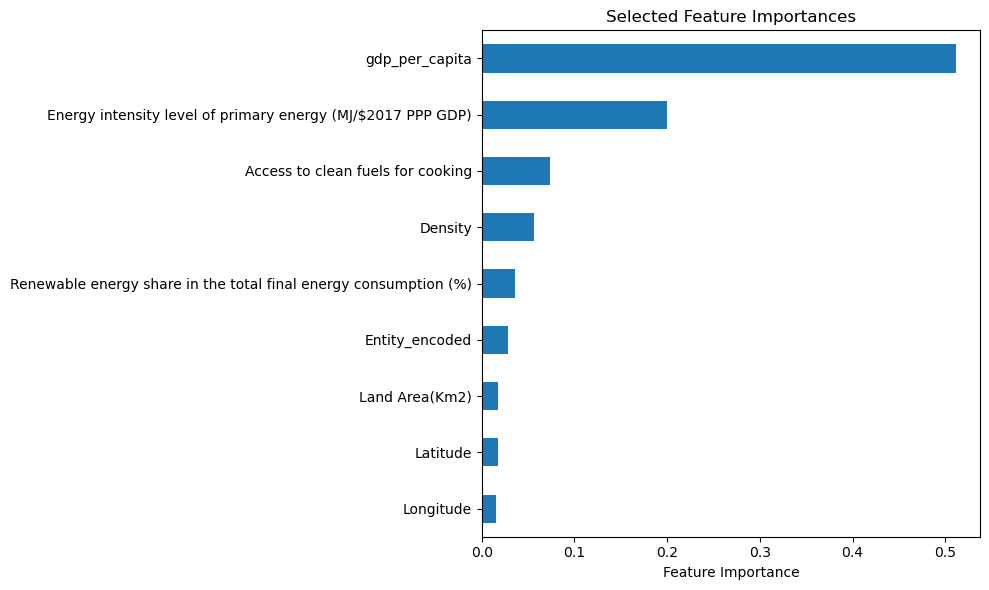

In [10]:
#feature selection using model-based approach
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
features = selector.fit_transform(X, y)
selected = selector.get_support()

selected_features = X.columns[selected].tolist()

#print selected features with numbering
print("\n--- Model-based Selection ---")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")
    

X_selected = X[selected_features]

#visualize selected features using bar plot
feature_importances = selector.estimator_.feature_importances_[selected]
feature_importances = pd.Series(feature_importances, index=selected_features).sort_values()
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Selected Feature Importances')
plt.tight_layout()
plt.show()



In [11]:
train = df.loc[df.Year < 2017]
test = df.loc[df.Year >= 2017]

Target = 'Primary energy consumption per capita (kWh/person)'

X_train = train[X_selected.columns]
y_train = train[Target]

X_test = test[X_selected.columns]
y_test = test[Target]

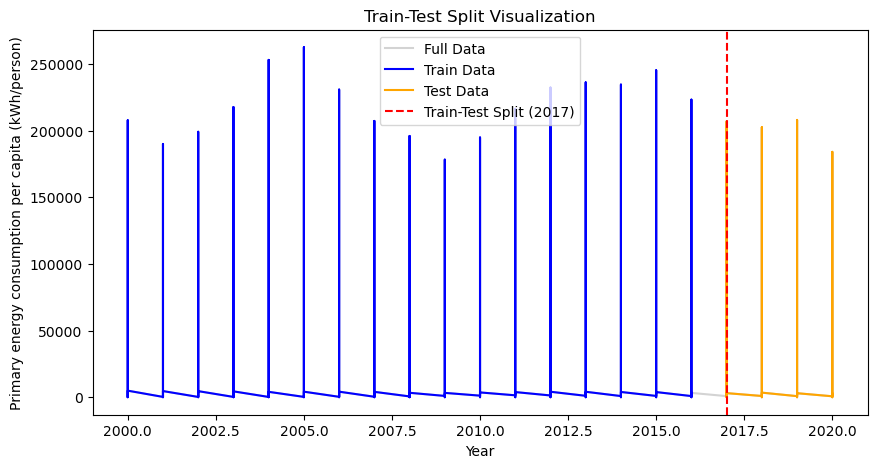

In [12]:
#add visualization for train and test split u
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df[Target], label='Full Data', color='lightgray')
plt.plot(train['Year'], y_train, label='Train Data', color='blue')
plt.plot(test['Year'], y_test, label='Test Data', color='orange')
plt.axvline(x=2017, color='red', linestyle='--', label='Train-Test Split (2017)')
plt.xlabel('Year')
plt.ylabel(Target)
plt.title('Train-Test Split Visualization')
plt.legend()
plt.show()

*Part 2: Model Training*  

In [13]:
final_model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Final Model R²: {r2:.4f}')
print(f'Final Model MAE: {mae:.4f}')

Final Model R²: 0.9656
Final Model MAE: 3119.3297


In [14]:
print(df.columns)

Index(['Entity', 'Year', 'Access to electricity (% of population)',
       'Access to clean fuels for cooking',
       'Renewable energy share in the total final energy consumption (%)',
       'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)',
       'Electricity from renewables (TWh)',
       'Low-carbon electricity (% electricity)',
       'Primary energy consumption per capita (kWh/person)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'Value_co2_emissions_kt_by_country', 'gdp_growth', 'gdp_per_capita',
       'Density', 'Land Area(Km2)', 'Latitude', 'Longitude', 'Entity_encoded'],
      dtype='object')


In [15]:
X_train, X_test, y_train, y_test= split(X_selected, y, test_size= 0.2, random_state=42)

In [16]:
#PCA

In [17]:
#model definition
results= []
models={}
models['lnr'] =LinearRegression()
models['knn'] =KNeighborsRegressor()
models['rfr'] =RandomForestRegressor()
models['mpr'] =MLPRegressor()
models['gbr'] =GradientBoostingRegressor()
models['dtr'] =DecisionTreeRegressor()
models['rrn'] =Ridge(alpha=10)
models['svr'] =SVR()

In [18]:
kf= KFold(n_splits=3, shuffle= True, random_state=42)

In [19]:
result_cp= []

for n in models:
    scores= cross_val_score(models[n], X_train, y_train, cv=kf, n_jobs=-1)
    print(f'model: {n} {scores.mean():.3%} +/- {scores.std():.3%}')

    result_cp.append({
        'Model': n,
        'R2 Mean': scores.mean()
    })

model: lnr 63.721% +/- 2.351%
model: knn 85.636% +/- 1.354%
model: rfr 97.236% +/- 1.314%
model: mpr 54.157% +/- 4.271%
model: gbr 96.357% +/- 0.311%
model: dtr 93.817% +/- 1.382%
model: rrn 63.721% +/- 2.351%
model: svr -13.154% +/- 1.184%


In [20]:
cp_df= pd.DataFrame(result_cp)
cp_df

,Model,R2 Mean
0,lnr,0.637211
1,knn,0.856355
2,rfr,0.972360
3,mpr,0.541567
4,gbr,0.963574
5,dtr,0.938170
6,rrn,0.637214
7,svr,-0.131539


In [21]:
scalers ={}
scalers['mms']= MinMaxScaler()
scalers['std']= StandardScaler()
scalers['rbs']= RobustScaler()


In [22]:
#finding the best scaler
results= []

for s in scalers:
    X_train_scaled= scalers[s].fit_transform(X_train)
    X_test_scaled= scalers[s].transform(X_test)
    print(f'---- With {s} scaling: ----\n')
    #model for loop
    for n in models:
        scores= cross_val_score(models[n], X_train_scaled, y_train ,cv= kf, n_jobs=-1)
        print(f'Models: {n}: {scores.mean():.3%} +/- {scores.std():.3%}')
        results.append({
            'Scaler': s, 
            'Model': n, 
            'R2 Mean':scores.mean()
            })

---- With mms scaling: ----

Models: lnr: 63.721% +/- 2.351%
Models: knn: 97.696% +/- 0.271%
Models: rfr: 97.208% +/- 1.287%
Models: mpr: -47.688% +/- 3.003%
Models: gbr: 96.335% +/- 0.298%
Models: dtr: 93.984% +/- 1.660%
Models: rrn: 61.587% +/- 3.216%
Models: svr: -12.738% +/- 1.284%
---- With std scaling: ----

Models: lnr: 63.721% +/- 2.351%
Models: knn: 96.989% +/- 0.662%
Models: rfr: 97.006% +/- 1.511%
Models: mpr: -41.939% +/- 3.296%
Models: gbr: 96.357% +/- 0.313%
Models: dtr: 94.184% +/- 2.681%
Models: rrn: 63.732% +/- 2.373%
Models: svr: -12.908% +/- 1.240%
---- With rbs scaling: ----

Models: lnr: 63.721% +/- 2.351%
Models: knn: 96.318% +/- 1.022%
Models: rfr: 96.966% +/- 1.573%
Models: mpr: -34.534% +/- 1.884%
Models: gbr: 96.348% +/- 0.320%
Models: dtr: 94.433% +/- 1.451%
Models: rrn: 63.723% +/- 2.332%
Models: svr: -12.776% +/- 1.207%


In [23]:
result_df= pd.DataFrame(results)

print(result_df)

   Scaler Model   R2 Mean
0     mms   lnr  0.637211
1     mms   knn  0.976958
2     mms   rfr  0.972078
3     mms   mpr -0.476875
4     mms   gbr  0.963351
5     mms   dtr  0.939844
6     mms   rrn  0.615869
7     mms   svr -0.127377
8     std   lnr  0.637211
9     std   knn  0.969890
10    std   rfr  0.970064
11    std   mpr -0.419390
12    std   gbr  0.963574
13    std   dtr  0.941843
14    std   rrn  0.637325
15    std   svr -0.129078
16    rbs   lnr  0.637211
17    rbs   knn  0.963183
18    rbs   rfr  0.969661
19    rbs   mpr -0.345337
20    rbs   gbr  0.963481
21    rbs   dtr  0.944334
22    rbs   rrn  0.637227
23    rbs   svr -0.127764


In [29]:
#robustscaler chosen as the scaler

#scl= RobustScaler()
scl= MinMaxScaler()
Xs_train= scl.fit_transform(X_train)
Xs_test= scl.transform(X_test)

KNN Performance Before Tuning

R2 Score: 0.974
RMSE: 5641.293


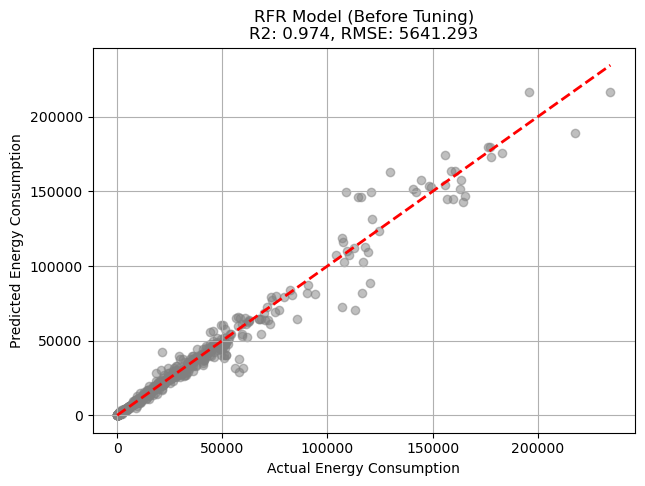

In [31]:
knn_bt =KNeighborsRegressor()
knn_bt.fit(X_train_scaled, y_train)
#knn k weight distance 
y_predb= knn_bt.predict(X_test_scaled)

r2b= r2_score(y_test, y_predb)
rmseb= np.sqrt(mean_squared_error(y_test, y_predb))

print(f"KNN Performance Before Tuning\n")
print(f"R2 Score: {r2b:.3f}")
print(f"RMSE: {rmseb:.3f}")


plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_predb, color='gray', alpha=0.5) 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'RFR Model (Before Tuning)\nR2: {r2b:.3f}, RMSE: {rmseb:.3f}')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.grid(True)
plt.show()


--- RFR Performance Before Tuning ---
R2 Score: 0.986
RMSE: 4204.553


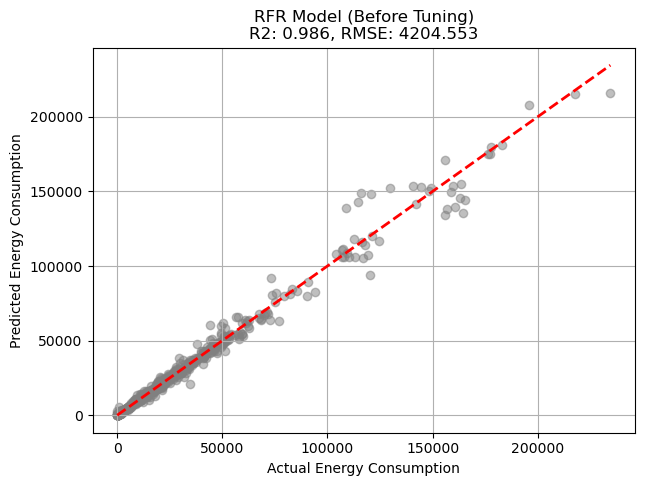

In [ ]:
#rfr_bt =RandomForestRegressor(random_state=42)
#rfr_bt.fit(X_train_scaled, y_train)
#knn k weight distance 
#y_predb= rfr_bt.predict(X_test_scaled)

#r2b= r2_score(y_test, y_predb)
#rmseb= np.sqrt(mean_squared_error(y_test, y_predb))

#print(f"\n--- RFR Performance Before Tuning ---")
#print(f"R2 Score: {r2b:.3f}")
#print(f"RMSE: {rmseb:.3f}")


#plt.figure(figsize=(7, 5))
#plt.scatter(y_test, y_predb, color='gray', alpha=0.5) 
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
#plt.title(f'RFR Model (Before Tuning)\nR2: {r2b:.3f}, RMSE: {rmseb:.3f}')
#plt.xlabel('Actual Energy Consumption')
#plt.ylabel('Predicted Energy Consumption')
#plt.grid(True)
#plt.show()

In [ ]:
#rfr= RandomForestRegressor().fit(X_train, y_train)
#print(f'Accuracy: {rfr.score(X_test, y_test):.3f}')

Accuracy: 0.987


Tuning KNeighbors
Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Final R2 Score: 0.988
Final RMSE: 3820.210


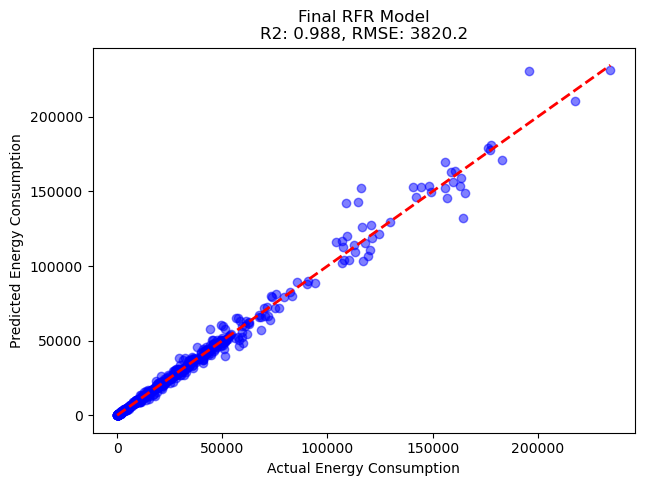

In [34]:
knn_pt= KNeighborsRegressor()
param_grid_knn_pt= {'n_neighbors': list(range(1,11)),
                    'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan']
                    }
#10,20... #1-20..

grid_knn_pt= GridSearchCV(estimator=knn_pt,
                          param_grid=param_grid_knn_pt, 
                          cv=kf, scoring='r2',n_jobs=-1, verbose=1)
print("Tuning KNeighbors")
grid_knn_pt.fit(X_train_scaled, y_train)

best_knn= grid_knn_pt.best_estimator_
y_pred= best_knn.predict(X_test_scaled)

fr2= r2_score(y_test, y_pred)
frmse= np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nBest Parameters: {grid_knn_pt.best_params_}")
print(f"Final R2 Score: {fr2:.3f}")
print(f"Final RMSE: {frmse:.3f}")

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Final RFR Model\nR2: {fr2:.3f}, RMSE: {frmse:.1f}')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.show()

In [38]:
fscores= grid_knn_pt.score(X_test_scaled, y_test)
print(f'Accuracy: {fscores:.3%} ')

Accuracy: 98.830% 
